In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import json
from SceneGraph3D.tools.load import load_3DSceneGraph
import bz2
import _pickle as cPickle
import math
import cv2
from PIL import Image as im

In [2]:
map_resolution = 5
max_actions = 500
global_map_size = 480

In [3]:
with open('val_episode_data.json', 'r') as f:
    episode_data = json.load(f)

In [4]:
val_scenes = ['Collierville', 'Darden', 'Markleeville','Wiconisco']
scene_graphs = {}
for scene in val_scenes:
    scene_graphs[scene], _ = load_3DSceneGraph(scene, "verified_graph")

In [5]:
with bz2.BZ2File('data/datasets/objectnav/gibson/v1.1/val/val_info.pbz2', 'rb') as f:
    dataset_info = cPickle.load(f)

In [6]:
def distance(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# Is success correlated with path statistics?

## Area coverage

In [17]:
success_areas = []
success_areas_norm = []
failure_areas = []
failure_areas_norm = []
for episode in episode_data:
    scene = episode["scene_id"][16:-4]
    area = episode["explored_area"] * (map_resolution/100)**2
    area_norm = area/scene_graphs[scene].floor_area
    if episode["success"]:
        success_areas.append(area)
        success_areas_norm.append(area_norm)
    else:
        failure_areas.append(area)
        failure_areas_norm.append(area_norm)

In [22]:
mean_success_area, mean_success_area_norm = np.mean(success_areas), np.mean(success_areas_norm)
mean_failure_area, mean_failure_area_norm = np.mean(failure_areas), np.mean(failure_areas_norm)
print("Mean success area:", mean_success_area)
print("Mean failure area:", mean_failure_area)
print("Mean success area normalized:", mean_success_area_norm)
print("Mean failure area normalized:", mean_failure_area_norm)

Mean success area: 43.952310607410475
Mean failure area: 48.33291011239119
Mean success area normalized: 1.0630147507508376
Mean failure area normalized: 1.1280835194294243


(array([[59., 33., 67., 64., 19., 23., 23., 17.,  2.,  6.],
        [36., 24., 25., 36., 15., 12., 12., 16.,  4.,  7.]]),
 array([  0.        ,  13.43356641,  26.86713281,  40.30069922,
         53.73426563,  67.16783203,  80.60139844,  94.03496484,
        107.46853125, 120.90209766, 134.33566406]),
 <a list of 2 BarContainer objects>)

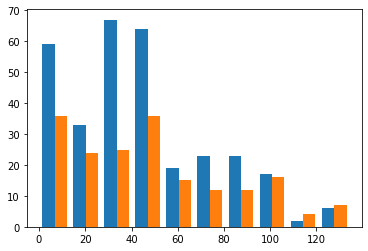

In [20]:
plt.hist((success_areas, failure_areas))

## Path length

In [34]:
success_lengths = []
success_lengths_norm = []
failure_lengths = []
failure_lengths_norm = []
for episode in episode_data:
    length = 0
    for step in range(1, len(episode["positions"])):
        length += distance(episode["positions"][step-1], episode["positions"][step])
    length *= (map_resolution/100)
    length_norm = length/episode["shortest_dist"]
    if episode["success"]:
        success_lengths.append(length)
        success_lengths_norm.append(length_norm)
    else:
        failure_lengths.append(length)
        failure_lengths_norm.append(length_norm)

In [35]:
mean_success_length, mean_success_length_norm = np.mean(success_lengths), np.mean(success_lengths_norm)
mean_failure_length, mean_failure_length_norm = np.mean(failure_lengths), np.mean(failure_lengths_norm)
print("Mean success length:", mean_success_length)
print("Mean failure length:", mean_failure_length)
print("Mean success length normalized:", mean_success_length_norm)
print("Mean failure length normalized:", mean_failure_length_norm)

Mean success length: 25.022981250958285
Mean failure length: 39.41584905135797
Mean success length normalized: 7.496934831762342
Mean failure length normalized: 9.802009683686409


(array([[140.,  74.,  41.,  29.,  14.,   6.,   2.,   4.,   3.,   0.],
        [ 69.,  35.,  26.,  14.,   3.,   9.,   5.,  10.,   6.,  10.]]),
 array([  0.        ,  14.78855205,  29.5771041 ,  44.36565615,
         59.1542082 ,  73.94276025,  88.7313123 , 103.51986435,
        118.3084164 , 133.09696845, 147.8855205 ]),
 <a list of 2 BarContainer objects>)

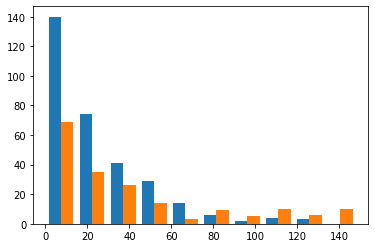

In [36]:
plt.hist((success_lengths, failure_lengths))

## Number of actions

In [37]:
success_actions = []
failure_actions = []
for episode in episode_data:
    num_actions = len(episode["positions"])
    if episode["success"]:
        success_actions.append(num_actions)
    else:
        failure_actions.append(num_actions)

In [38]:
mean_success_action = np.mean(success_actions)
mean_failure_action = np.mean(failure_actions)
print("Mean success action:", mean_success_action)
print("Mean failure action:", mean_failure_action)

Mean success action: 115.22683706070288
Mean failure action: 241.68449197860963


In [46]:
action_limit_reached = np.sum(np.array(failure_actions) == max_actions-1)
total_failures = len(failure_actions)
print("Total failures:", total_failures)
print("Action limit reached:", action_limit_reached)

Total failures: 187
Action limit reached: 64


# Is success correlated with object properties?

# What role does the global policy play?

In [110]:
def render_goals(episode_idx):
    episode = episode_data[episode_idx]
    
    episode = {'episode_id': 1, 'scene_id': 'gibson_semantic/Markleeville.glb', 'start_position': [5.423199653625488, 0.18220996856689453, -2.286238193511963], 'start_rotation': [-0.5497498992476785, 0.0, 0.8353293052905347, 0.0], 'object_category': 'bed', 'object_id': 3, 'floor_id': 0, 'shortest_dist': 4.397844692930243, 'positions': [[240, 240], [240, 240], [240, 240], [245, 240], [250, 240], [255, 240], [255, 240], [259, 242], [263, 245], [267, 247], [272, 250], [272, 250], [272, 250], [272, 255], [272, 255], [274, 259], [277, 263], [279, 267], [282, 272], [284, 276], [287, 280], [287, 280], [287, 280], [292, 280], [297, 280], [297, 280], [297, 280], [297, 280], [297, 280], [297, 280], [292, 283], [288, 285], [284, 288], [279, 290], [275, 293], [271, 295], [271, 295], [268, 300], [266, 304], [262, 306], [262, 306], [261, 307], [261, 307], [261, 307], [261, 307], [259, 308], [257, 309], [257, 309], [258, 308], [258, 308], [258, 308], [258, 308], [258, 308], [258, 308], [258, 308], [258, 308], [258, 308], [258, 308], [258, 308], [258, 308], [258, 308], [262, 307], [262, 307], [265, 305], [265, 305], [265, 305], [263, 306], [263, 306], [263, 306], [263, 306], [263, 306], [259, 304], [254, 301], [250, 299], [246, 296], [241, 294], [237, 291], [233, 289], [228, 286], [224, 284], [220, 281], [220, 281], [220, 281], [220, 276], [220, 271], [220, 266], [220, 261], [220, 256], [220, 251], [220, 246], [220, 241], [220, 236], [220, 231], [220, 226], [220, 226], [222, 222], [225, 218], [225, 218], [226, 213], [226, 208], [226, 208], [226, 208], [226, 208], [226, 208], [226, 208], [226, 208], [230, 210], [235, 213], [239, 216], [239, 216], [244, 216], [244, 216], [248, 213], [253, 211], [257, 208], [257, 208], [260, 204], [260, 204], [260, 204], [260, 204], [260, 204], [260, 204], [260, 204], [257, 208], [257, 208], [253, 211], [248, 213], [244, 216], [244, 216], [239, 216], [239, 216], [235, 213], [235, 213], [232, 209], [230, 205], [227, 200], [225, 196], [222, 192], [220, 187], [217, 183], [215, 179], [212, 175], [210, 170], [207, 166], [205, 162], [202, 157], [200, 153], [200, 153], [200, 148], [200, 143], [200, 138], [200, 133], [200, 128], [200, 123], [200, 123], [202, 119], [202, 119], [202, 119], [207, 119], [207, 119], [212, 121], [216, 124], [220, 126], [220, 126], [220, 126], [220, 131], [220, 131], [220, 131], [220, 131], [220, 131], [220, 131], [220, 131], [220, 126], [220, 121], [220, 116], [220, 111], [220, 111], [222, 107], [225, 103], [228, 99], [228, 99], [228, 99], [228, 99], [228, 99], [228, 99], [228, 99], [228, 99], [224, 102], [224, 102], [219, 103], [214, 103], [214, 103], [210, 106], [206, 108], [201, 111], [201, 111], [197, 112], [197, 112], [192, 114], [188, 117], [184, 119], [179, 122], [175, 124]], 'goal_rewards': [-0.2347056492225445, -0.018081097286063483, 0.06149526268893232, 0.4659508495622255, -0.1637495863121759, 0.3255413565293171, -0.14416666666666803, 0.13972228277340162], 'explore_rewards': [18.748615264892578, 5.027400016784668, 9.992716789245605, 14.905428886413574, 13.018388748168945, 10.9253511428833, 8.607362747192383, 7.601572036743164], 'policy_goals': [([266, 379], 0.844184935092926), ([149, 361], 0.6485704779624939), ([131, 231], 0.4060139060020447), ([341, 93], 0.28530353307724), ([327, 125], 0.43771815299987793), ([302, 139], 0.41312918066978455), ([270, 21], 0.26316919922828674), ([151, 59], 0.2909016013145447)], 'used_policy': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False], 'success': 1, 'spl': 0.15707145122408414, 'distance_to_goal': 0.0, 'explored_area': 38471.4765625}    
    scene = episode["scene_id"][16:-4]
    sem_map = dataset_info[scene][episode["floor_id"]]["sem_map"][0]
    goal_map = sem_map[episode["object_id"]].astype(int)
    map_obj_origin = dataset_info[scene][episode["floor_id"]]['origin']
    print("map orig", map_obj_origin)
    print("goal map dims", sem_map.shape)
    pos = episode["start_position"]
    x = -pos[2]
    y = -pos[0]
    min_x, min_y = map_obj_origin / 100.0
    start_y, start_x = int((-y - min_y) * 20.), int((-x - min_x) * 20.)
    plt.scatter(start_x, start_y, color="green")
    print("a", start_x, start_y)
    start_x, start_y = 240-start_x, 240-start_x
#     print(np.sum(goal_map))
#     sem_map = np.sum(sem_map, axis=0)
#     print(np.sum(goal_map))
#     sem_map[sem_map > 0] = 2
#     sem_map[goal_map] = 4
    plt.imshow(sem_map)
    goal_x = []
    goal_y = []
    for goal in episode["policy_goals"]:
        x = goal[0][0]
        y = goal[0][1]
        #y, x = int((-y - min_y) * 20.), int((-x - min_x) * 20.)
        goal_x.append(x)
        goal_y.append(y)
    #plt.scatter(goal_x, goal_y)
    for step in range(1, len(episode["positions"])):
        print(episode["positions"][step-1][0])
        endpt1_x = episode["positions"][step-1][0] - start_x
        endpt2_x = episode["positions"][step][0] - start_x
        endpt1_y = 266 - (episode["positions"][step-1][1] - start_y)
        endpt2_y = 266 - (episode["positions"][step][1] - start_y)
        plt.plot([endpt1_x, endpt2_x], [endpt1_y, endpt2_y], color="red")
    plt.show()
    x = "Success" if episode["success"] else "Failure"
    print(x)

map orig [-757 -299]
goal map dims (266, 206)
a 105 168
240
240
240
245
250
255
255
259
263
267
272
272
272
272
272
274
277
279
282
284
287
287
287
292
297
297
297
297
297
297
292
288
284
279
275
271
271
268
266
262
262
261
261
261
261
259
257
257
258
258
258
258
258
258
258
258
258
258
258
258
258
262
262
265
265
265
263
263
263
263
263
259
254
250
246
241
237
233
228
224
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
222
225
225
226
226
226
226
226
226
226
226
230
235
239
239
244
244
248
253
257
257
260
260
260
260
260
260
260
257
257
253
248
244
244
239
239
235
235
232
230
227
225
222
220
217
215
212
210
207
205
202
200
200
200
200
200
200
200
200
200
202
202
202
207
207
212
216
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
222
225
228
228
228
228
228
228
228
228
224
224
219
214
214
210
206
201
201
197
197
192
188
184
179


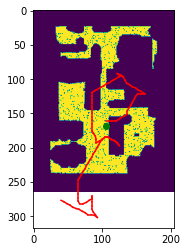

Success


In [111]:
sem_map = render_goals(4)
#print(np.sum(sem_map==4))
#cmap = colors.ListedColormap(['white', 'blue', 'red'])
#bounds=[-1,1,3,5]
#norm = colors.BoundaryNorm(bounds, cmap.N)
#plt.imshow(sem_map, cmap=cmap)


map orig [-911 -431]
goal map dims (149, 239)


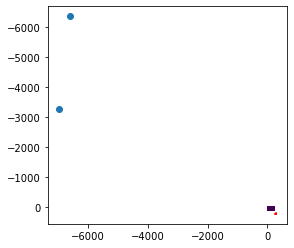

Success


In [37]:
sem_map = render_goals(0)

# What is the distribution of failure modes?

## Failure cases: object found vs not found

In [159]:
seen_dtg = []
not_seen_dtg = []
for episode in episode_data:
    if not episode["success"]:
        if not episode["used_policy"][-1]:
            seen_dtg.append(episode["distance_to_goal"])
        else:
            not_seen_dtg.append(episode["distance_to_goal"])

In [160]:
num_seen_fails, mean_dtg_seen = len(seen_dtg), np.mean(seen_dtg)
num_not_seen_fails, mean_dtg_not_seen = len(not_seen_dtg), np.mean(not_seen_dtg)
print("Number failures when object seen:", num_seen_fails)
print("DTG when object seen:", mean_dtg_seen)
print("Number failures when object not seen:", num_not_seen_fails)
print("DTG when object not seen:", mean_dtg_not_seen)

Number failures when object seen: 132
DTG when object seen: 3.3398381264561485
Number failures when object not seen: 55
DTG when object not seen: 6.472432422424199


## Object not found cases: detection errors vs exploration errors

In [26]:
for episode in episode_data[3:]:
    print("positions", episode["positions"])
    scene = episode["scene_id"][16:-4]
    sem_map = dataset_info[scene][episode["floor_id"]]["sem_map"][episode["object_id"]]
    print(sem_map.shape)
    pos = episode["start_position"]
    map_obj_origin = dataset_info[scene][episode["floor_id"]]['origin']
    print("start_pos", pos)
    print("map_origin", map_obj_origin)
    x = -pos[2]
    y = -pos[0]
    min_x, min_y = map_obj_origin / 100.0
    map_loc = int((-y - min_y) * 20.), int((-x - min_x) * 20.)
    print(map_loc)
    break

positions [[126.0, 126.0], [126.0, 126.0], [126.0, 126.0], [126.0, 126.0], [126.0, 126.0], [126.0, 126.0], [126.0, 126.0], [123.0, 121.0], [121.0, 117.0], [118.0, 113.0], [116.0, 108.0], [114.0, 103.0], [114.0, 103.0], [114.0, 98.0], [114.0, 98.0], [111.0, 94.0], [111.0, 94.0], [111.0, 89.0], [111.0, 84.0], [111.0, 79.0], [111.0, 74.0], [111.0, 69.0], [111.0, 69.0], [114.0, 65.0], [114.0, 65.0], [122.95, 125.4], [122.95, 125.4], [122.95, 125.4], [122.95, 125.4], [117.95, 125.4], [112.95, 122.4], [112.95, 122.4], [110.95, 118.4], [107.95, 114.4], [105.95, 109.4], [102.95, 105.4], [100.95, 101.4], [100.95, 101.4], [100.95, 96.4], [100.95, 91.4], [100.95, 86.4]]
(415, 186)
start_pos [-1.5259437561035156, 0.13282066583633423, -0.8541572093963623]
map_origin [ -499 -1803]
(330, 82)


# Map Alignment

In [129]:
def global_to_gt_map(mp, episode):
    global_start_rot = episode["positions"][0][2]
    gt_start_pos = episode["gt_positions"][0]
    gt_start_y, gt_start_x, gt_start_rot = gt_start_pos
    gt_start_rot = math.radians(gt_start_rot - global_start_rot)
    T1 = np.float32([[1, 0, -global_map_size//2], [0, 1, -global_map_size//2], [0, 0, 1]])
    R = np.float32([[math.cos(gt_start_rot), -math.sin(gt_start_rot), 0], [math.sin(gt_start_rot), math.cos(gt_start_rot), 0], [0, 0, 1]])
    T2 = np.float32([[1, 0, gt_start_x], [0, 1, gt_start_y], [0, 0, 1]])
    transform = T2 @ R @ T1
    rot_map = cv2.warpAffine(mp, transform[:2,:], mp.shape)
    return rot_map

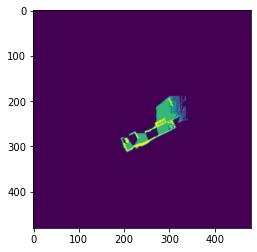

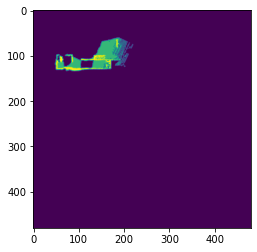

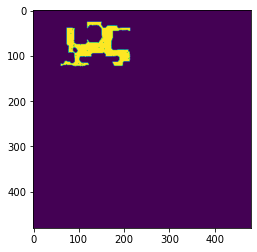

In [143]:
episode = {'episode_id': 0, 'scene_id': 'gibson_semantic/Wiconisco.glb', 'start_position': [0.5152035355567932, 0.033231496810913086, -2.4201502799987793], 'start_rotation': [-0.16431138411057558, 0.0, 0.9864085203665197, 0.0], 'object_category': 'toilet', 'object_id': 4, 'floor_id': 0, 'shortest_dist': 6.613368390177556, 'positions': [[240, 240, 0.0], [240, 240, 30.0], [242, 244, 30.0], [245, 248, 30.0], [247, 252, 30.0], [250, 257, 30.0], [252, 261, 30.0], [252, 261, 60.0], [252, 261, 90.0], [257, 261, 90.0], [257, 261, 60.0], [261, 264, 60.0], [266, 266, 60.0], [270, 269, 60.0], [274, 271, 60.0], [279, 274, 60.0], [283, 276, 60.0], [287, 279, 60.0], [292, 281, 60.0], [296, 284, 60.0], [300, 286, 60.0], [300, 286, 30.0], [300, 286, 0.0], [300, 291, 0.0], [300, 291, 30.0], [303, 295, 30.0], [303, 295, 60.0], [303, 295, 90.0], [303, 295, 120.0], [303, 295, 150.0], [304, 292, 150.0], [306, 286, 150.0], [308, 282, 150.0], [311, 278, 150.0], [313, 273, 150.0], [316, 269, 150.0], [318, 265, 150.0], [321, 260, 150.0], [323, 256, 150.0], [326, 252, 150.0], [328, 247, 150.0], [331, 243, 150.0], [333, 239, 150.0], [333, 239, 120.0], [333, 239, 90.0], [338, 239, 90.0], [338, 239, 60.0], [338, 239, 30.0], [338, 239, 0.0], [339, 242, 0.0], [339, 242, -30.0], [339, 242, -60.0], [335, 241, -60.0], [335, 241, -90.0], [335, 241, -120.0], [335, 241, -150.0], [335, 241, -180.0], [335, 241, 150.0], [338, 237, 150.0], [340, 233, 150.0], [343, 228, 150.0], [345, 224, 150.0], [347, 219, 150.0], [350, 214, 150.0], [352, 210, 150.0], [352, 210, 120.0], [352, 210, 150.0], [355, 206, 150.0], [357, 201, 150.0], [360, 197, 150.0], [362, 193, 150.0], [362, 193, -180.0], [362, 188, -180.0], [362, 188, 150.0], [365, 183, 150.0], [367, 179, 150.0], [370, 175, 150.0], [370, 175, -180.0], [370, 170, -180.0], [370, 165, -180.0], [370, 160, -180.0], [370, 155, -180.0], [370, 155, 150.0], [372, 150, 150.0], [375, 146, 150.0], [377, 142, 150.0], [380, 138, 150.0], [380, 138, -180.0], [380, 133, -180.0], [380, 133, 150.0], [383, 129, 150.0], [383, 129, -180.0], [383, 129, -150.0], [380, 124, -150.0], [378, 120, -150.0], [378, 120, -120.0], [373, 117, -120.0], [369, 115, -120.0], [365, 112, -120.0], [365, 112, -90.0], [360, 112, -90.0], [355, 112, -90.0], [350, 111, -90.0], [345, 111, -90.0], [340, 111, -90.0], [335, 111, -90.0], [330, 111, -90.0], [325, 111, -90.0], [320, 111, -90.0], [315, 111, -90.0], [311, 113, -90.0], [311, 113, -120.0], [307, 111, -120.0], [302, 108, -120.0], [302, 108, -150.0], [302, 108, -180.0], [302, 103, -180.0], [302, 103, 150.0], [302, 103, -180.0], [302, 103, -150.0], [300, 99, -150.0], [297, 94, -150.0], [297, 94, -120.0], [297, 94, -90.0], [297, 94, -60.0], [297, 94, -30.0], [297, 94, 0.0], [297, 99, 0.0], [298, 104, 0.0], [298, 104, 30.0], [300, 109, 30.0], [300, 109, 0.0], [302, 114, 0.0], [302, 114, -30.0], [299, 119, -30.0], [297, 123, -30.0], [294, 127, -30.0], [293, 132, -30.0], [290, 137, -30.0], [288, 141, -30.0], [286, 146, -30.0], [285, 150, -30.0], [282, 155, -30.0], [280, 159, -30.0], [277, 163, -30.0], [275, 168, -30.0], [272, 172, -30.0], [270, 176, -30.0], [270, 176, 0.0], [270, 181, 0.0], [270, 186, 0.0], [271, 192, 0.0], [271, 192, -30.0], [271, 192, -60.0], [267, 195, -60.0], [267, 195, -30.0], [264, 200, -30.0], [264, 200, -60.0], [260, 202, -60.0], [260, 202, -30.0], [258, 206, -30.0], [255, 211, -30.0], [253, 215, -30.0], [252, 220, -30.0], [252, 220, -60.0], [250, 223, -60.0], [246, 226, -60.0], [246, 226, -90.0], [241, 226, -90.0], [236, 226, -90.0], [231, 226, -90.0], [226, 226, -90.0], [221, 226, -90.0], [216, 226, -90.0], [211, 226, -90.0], [206, 226, -90.0], [201, 226, -90.0], [196, 226, -90.0], [191, 226, -90.0], [186, 226, -90.0], [181, 226, -90.0], [176, 226, -90.0], [171, 226, -90.0], [166, 226, -90.0], [166, 226, -60.0], [162, 228, -60.0], [158, 232, -60.0], [154, 235, -60.0], [154, 235, -90.0], [149, 235, -90.0], [149, 235, -60.0], [144, 237, -60.0], [140, 240, -60.0], [136, 242, -60.0], [131, 245, -60.0], [127, 247, -60.0], [127, 247, -90.0], [122, 247, -90.0], [122, 247, -60.0], [118, 250, -60.0], [113, 252, -60.0], [113, 252, -90.0], [113, 252, -120.0], [113, 252, -150.0], [113, 252, -120.0], [113, 252, -90.0], [113, 252, -60.0], [113, 252, -30.0], [113, 252, 0.0], [113, 252, 30.0], [113, 252, 60.0], [113, 252, 90.0], [113, 252, 120.0], [113, 252, 150.0], [116, 248, 150.0], [116, 248, 120.0], [120, 245, 120.0], [124, 243, 120.0], [129, 240, 120.0], [133, 238, 120.0], [138, 236, 120.0], [142, 233, 120.0], [142, 233, 150.0], [142, 233, -180.0], [143, 228, -180.0], [143, 223, -180.0], [143, 218, -180.0], [143, 213, -180.0], [143, 208, -180.0], [143, 203, -180.0], [143, 203, 150.0], [145, 199, 150.0], [148, 194, 150.0], [150, 190, 150.0], [153, 186, 150.0], [156, 182, 150.0], [156, 182, -180.0], [157, 177, -180.0], [157, 172, -180.0], [157, 167, -180.0], [157, 167, -150.0], [157, 167, -120.0], [153, 164, -120.0], [153, 164, -90.0], [148, 164, -90.0]], 'gt_positions': [(160, 206, 18.914466666423493), (160, 206, 48.91446653283421), (163, 209, 48.91446653283421), (167, 212, 48.91446653283421), (171, 216, 48.91446653283421), (175, 219, 48.91446653283421), (178, 222, 48.91446653283421), (178, 222, 78.91446428383033), (178, 222, 108.91446383253279), (183, 221, 108.91446383253279), (183, 221, 78.91446428383033), (188, 221, 78.91446428383033), (193, 222, 78.91446428383033), (198, 223, 78.91446428383033), (203, 224, 78.91446428383033), (208, 225, 78.91446428383033), (213, 226, 78.91446428383033), (218, 227, 78.91446428383033), (222, 228, 78.91446428383033), (227, 229, 78.91446428383033), (232, 230, 78.91446428383033), (232, 230, 48.91446653283421), (232, 230, 18.914464982084297), (234, 235, 18.914464982084297), (234, 235, 48.91446653283421), (238, 238, 48.91446653283421), (238, 238, 78.91446428383033), (238, 238, 108.91446383253279), (238, 238, 138.91446446720929), (238, 238, 168.91446235105636), (238, 234, 168.91446235105636), (237, 229, 168.91446235105636), (238, 224, 168.91446235105636), (239, 219, 168.91446235105636), (240, 214, 168.91446235105636), (241, 209, 168.91446235105636), (242, 204, 168.91446235105636), (243, 199, 168.91446235105636), (244, 194, 168.91446235105636), (245, 189, 168.91446235105636), (246, 184, 168.91446235105636), (247, 179, 168.91446235105636), (248, 175, 168.91446235105636), (248, 175, 138.9144612692789), (248, 175, 108.9144622453926), (253, 173, 108.9144622453926), (253, 173, 78.91446862442973), (253, 173, 48.914472469287716), (253, 173, 18.914471719440996), (254, 176, 18.914471719440996), (254, 176, 348.91446914931015), (254, 176, 318.9144708630702), (251, 177, 318.9144708630702), (251, 177, 288.9144678029934), (251, 177, 258.91446862442973), (251, 177, 228.91447246928774), (251, 177, 198.91447171944097), (251, 177, 168.91446914931007), (252, 172, 168.91446914931007), (253, 167, 168.91446914931007), (254, 162, 168.91446914931007), (255, 157, 168.91446914931007), (255, 151, 168.91446914931007), (256, 146, 168.91446914931007), (257, 141, 168.91446914931007), (257, 141, 138.91447086307022), (257, 141, 168.91446914931007), (258, 137, 168.91446914931007), (258, 132, 168.91446914931007), (259, 127, 168.91446914931007), (260, 122, 168.91446914931007), (260, 122, 198.91446835076272), (259, 117, 198.91446835076272), (259, 117, 168.91446575018324), (260, 112, 168.91446575018324), (261, 107, 168.91446575018324), (262, 102, 168.91446575018324), (262, 102, 198.91446329774507), (260, 98, 198.91446329774507), (258, 93, 198.91446329774507), (257, 88, 198.91446329774507), (255, 83, 198.91446329774507), (255, 83, 168.91446235105636), (256, 79, 168.91446235105636), (257, 74, 168.91446235105636), (258, 69, 168.91446235105636), (259, 64, 168.91446235105636), (259, 64, 198.91445992906674), (258, 59, 198.91445992906674), (258, 59, 168.9144589519294), (259, 54, 168.9144589519294), (259, 54, 198.91445656038826), (259, 54, 228.91446031551413), (255, 51, 228.91446031551413), (252, 48, 228.91446031551413), (252, 48, 258.914459010247), (247, 47, 258.914459010247), (242, 46, 258.914459010247), (237, 45, 258.914459010247), (237, 45, 288.9144622453926), (232, 46, 288.9144622453926), (227, 48, 288.9144622453926), (223, 49, 288.9144622453926), (218, 50, 288.9144622453926), (213, 52, 288.9144622453926), (209, 53, 288.9144622453926), (204, 55, 288.9144622453926), (199, 57, 288.9144622453926), (194, 58, 288.9144622453926), (190, 60, 288.9144622453926), (186, 63, 288.9144622453926), (186, 63, 258.91446862442973), (181, 62, 258.91446862442973), (176, 61, 258.91446862442973), (176, 61, 228.91447246928774), (176, 61, 198.91447171944097), (175, 56, 198.91447171944097), (175, 56, 168.91446914931007), (175, 56, 198.91446835076272), (175, 56, 228.9144665328342), (171, 53, 228.9144665328342), (167, 50, 228.9144665328342), (167, 50, 258.91446428383034), (167, 50, 288.91446383253276), (167, 50, 318.9144644672093), (167, 50, 348.91446235105633), (167, 50, 18.91445992906668), (169, 54, 18.91445992906668), (171, 59, 18.91445992906668), (171, 59, 48.914460315514106), (175, 62, 48.914460315514106), (175, 62, 18.914458244727456), (178, 67, 18.914458244727456), (178, 67, 348.914457252366), (177, 72, 348.914457252366), (176, 77, 348.914457252366), (175, 82, 348.914457252366), (175, 87, 348.914457252366), (174, 92, 348.914457252366), (174, 97, 348.914457252366), (174, 102, 348.914457252366), (174, 107, 348.914457252366), (173, 112, 348.914457252366), (172, 117, 348.914457252366), (171, 121, 348.914457252366), (170, 126, 348.914457252366), (169, 131, 348.914457252366), (168, 136, 348.914457252366), (168, 136, 18.91445656038826), (169, 141, 18.91445656038826), (171, 146, 18.91445656038826), (174, 150, 18.91445656038826), (174, 150, 348.91445555280256), (174, 150, 318.9144556745908), (171, 155, 318.9144556745908), (171, 155, 348.9144530034574), (170, 160, 348.9144530034574), (170, 160, 318.91445247666036), (167, 164, 318.91445247666036), (167, 164, 348.9144504541123), (166, 169, 348.9144504541123), (165, 173, 348.9144504541123), (164, 178, 348.9144504541123), (165, 183, 348.9144504541123), (165, 183, 318.91445247666036), (165, 187, 318.91445247666036), (161, 191, 318.91445247666036), (161, 191, 288.9144471597311), (157, 192, 288.9144471597311), (152, 194, 288.9144471597311), (147, 196, 288.9144471597311), (142, 197, 288.9144471597311), (138, 199, 288.9144471597311), (133, 201, 288.9144471597311), (128, 202, 288.9144471597311), (123, 204, 288.9144471597311), (119, 205, 288.9144471597311), (114, 207, 288.9144471597311), (109, 209, 288.9144471597311), (105, 210, 288.9144471597311), (100, 212, 288.9144471597311), (95, 214, 288.9144471597311), (90, 215, 288.9144471597311), (86, 217, 288.9144471597311), (86, 217, 318.9144468819717), (82, 221, 318.9144468819717), (80, 225, 318.9144468819717), (77, 229, 318.9144468819717), (77, 229, 288.9144471597311), (72, 231, 288.9144471597311), (72, 231, 318.9144468819717), (69, 234, 318.9144468819717), (65, 238, 318.9144468819717), (62, 242, 318.9144468819717), (59, 246, 318.9144468819717), (56, 249, 318.9144468819717), (56, 249, 288.9144471597311), (51, 251, 288.9144471597311), (51, 251, 318.9144468819717), (48, 255, 318.9144468819717), (44, 259, 318.9144468819717), (44, 259, 288.9144471597311), (44, 259, 258.9144493960645), (44, 259, 228.91445127040112), (44, 259, 258.9144493960645), (44, 259, 288.91445271733124), (44, 259, 318.9144548734184), (44, 259, 348.9144521536757), (44, 259, 18.914452069432826), (44, 259, 48.914451270401116), (44, 259, 78.91444939606454), (44, 259, 108.91445271733124), (44, 259, 138.91445487341835), (44, 259, 168.9144521536757), (45, 254, 168.9144521536757), (45, 254, 138.91445247666036), (48, 250, 138.91445247666036), (52, 246, 138.91445247666036), (55, 242, 138.91445247666036), (58, 239, 138.91445247666036), (62, 235, 138.91445247666036), (65, 231, 138.91445247666036), (65, 231, 168.91445045411223), (65, 231, 198.9144503850937), (64, 226, 198.9144503850937), (63, 221, 198.9144503850937), (61, 217, 198.9144503850937), (60, 212, 198.9144503850937), (58, 207, 198.9144503850937), (56, 202, 198.9144503850937), (56, 202, 168.9144511138324), (57, 197, 168.9144511138324), (58, 193, 168.9144511138324), (59, 188, 168.9144511138324), (61, 183, 168.9144511138324), (62, 178, 168.9144511138324), (62, 178, 198.91445206943285), (61, 173, 198.91445206943285), (60, 168, 198.91445206943285), (58, 164, 198.91445206943285), (58, 164, 228.91445127040112), (58, 164, 258.9144493960645), (54, 163, 258.9144493960645), (54, 163, 288.91445271733124), (49, 164, 288.91445271733124)], 'goal_rewards': [-0.31527706347992634, -0.06080621369948656, -0.19743638125018087, -0.22044643059130797, 0.06494799777006455, 0.5883579156244989, 0.42493715187002484, -0.005524445702499967, 0.22438292526348222], 'explore_rewards': [25.58387565612793, 13.648720741271973, 17.007343292236328, 12.428085327148438, 5.365732192993164, 7.563817977905273, 18.25959014892578, 14.523720741271973, 8.212577819824219], 'policy_goals': [([313, 315], 1.570914387702942), ([347, 246], 1.3548893928527832), ([446, 263], 0.9527016878128052), ([462, 91], 1.0562946796417236), ([404, 61], 0.9484309554100037), ([184, 131], 0.7558674812316895), ([154, 245], 0.5645246505737305), ([91, 265], 0.6561113595962524), ([13, 305], 1.1448367834091187), ([107, 151], 0.8486160635948181)], 'used_policy': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False], 'action': 2, 'success': 1, 'spl': 0.1649438195463693, 'distance_to_goal': 0.0, 'explored_area': 49037.38671875}
episode = {'episode_id': 1, 'scene_id': 'gibson_semantic/Wiconisco.glb', 'start_position': [-1.265192985534668, 0.033231496810913086, -1.2045917510986328], 'start_rotation': [0.9960016206576754, 0.0, 0.0893351646737389, 0.0], 'object_category': 'potted plant', 'object_id': 2, 'floor_id': 0, 'shortest_dist': 1.7219357556097445, 'positions': [[240, 240, 30.0], [240, 240, 60.0], [240, 240, 90.0], [240, 240, 120.0], [240, 240, 150.0], [242, 235, 150.0], [245, 231, 150.0], [245, 231, -180.0], [245, 226, -180.0], [245, 226, 150.0], [247, 222, 150.0], [250, 217, 150.0], [252, 213, 150.0], [256, 210, 150.0], [256, 210, -180.0], [257, 205, -180.0], [257, 200, -180.0], [257, 195, -180.0], [257, 190, -180.0], [257, 185, -180.0], [257, 180, -180.0], [257, 180, -150.0], [254, 180, -150.0], [254, 180, -180.0], [253, 179, -180.0], [253, 179, 150.0], [253, 179, 120.0], [253, 179, 90.0], [253, 179, 60.0], [253, 179, 30.0], [253, 179, 0.0], [253, 184, 0.0], [253, 189, 0.0], [253, 189, 30.0], [255, 194, 30.0], [258, 198, 30.0], [258, 198, 0.0], [258, 203, 0.0], [258, 203, -30.0], [257, 207, -30.0], [254, 212, -30.0], [252, 216, -30.0], [249, 220, -30.0], [247, 225, -30.0], [244, 229, -30.0], [244, 229, 0.0], [244, 234, 0.0], [244, 239, 0.0], [244, 244, 0.0], [244, 249, 0.0], [244, 249, -30.0], [244, 249, -60.0], [244, 249, -90.0], [239, 249, -90.0], [239, 249, -60.0], [235, 252, -60.0], [235, 252, -90.0], [230, 252, -90.0], [230, 252, -60.0], [225, 254, -60.0], [221, 257, -60.0], [217, 259, -60.0], [212, 262, -60.0], [208, 264, -60.0], [204, 267, -60.0], [204, 267, -90.0], [199, 267, -90.0], [199, 267, -60.0], [194, 269, -60.0], [190, 272, -60.0], [190, 272, -30.0], [188, 276, -30.0], [185, 280, -30.0], [183, 285, -30.0], [180, 289, -30.0], [180, 289, -60.0], [180, 289, -90.0], [180, 289, -120.0], [176, 286, -120.0], [171, 284, -120.0], [167, 281, -120.0], [167, 281, -90.0], [162, 281, -90.0], [157, 281, -90.0], [152, 281, -90.0], [147, 281, -90.0], [142, 281, -90.0], [137, 281, -90.0], [132, 281, -90.0], [127, 281, -90.0], [122, 281, -90.0], [117, 281, -90.0]], 'gt_positions': [(124, 230, 220.25072265361825), (124, 230, 250.25072203890133), (124, 230, 280.25072271774326), (124, 230, 310.2507186892544), (124, 230, 340.25072003542954), (122, 235, 340.25072003542954), (121, 239, 340.25072003542954), (121, 239, 10.250720412569194), (122, 244, 10.250720412569194), (122, 244, 340.25072171768), (120, 249, 340.25072171768), (118, 254, 340.25072171768), (116, 258, 340.25072171768), (113, 262, 340.25072171768), (113, 262, 10.250722113288987), (113, 267, 10.250722113288987), (114, 272, 10.250722113288987), (115, 277, 10.250722113288987), (116, 282, 10.250722113288987), (117, 287, 10.250722113288987), (118, 292, 10.250722113288987), (118, 292, 40.25071944704243), (121, 292, 40.25071944704243), (121, 292, 10.250719562209298), (122, 292, 10.250719562209298), (122, 292, 340.25072171768), (122, 292, 310.2507217875316), (122, 292, 280.25072271774326), (122, 292, 250.25071810903376), (122, 292, 220.25071944704243), (122, 292, 190.2507195622092), (121, 287, 190.2507195622092), (120, 282, 190.2507195622092), (120, 282, 220.25071944704243), (117, 278, 220.25071944704243), (113, 274, 220.25071944704243), (113, 274, 190.2507195622092), (113, 269, 190.2507195622092), (113, 269, 160.25072171768), (113, 265, 160.25072171768), (115, 260, 160.25072171768), (116, 255, 160.25072171768), (118, 250, 160.25072171768), (120, 246, 160.25072171768), (121, 241, 160.25072171768), (121, 241, 190.25072211328902), (120, 236, 190.25072211328902), (120, 231, 190.25072211328902), (119, 226, 190.25072211328902), (118, 221, 190.25072211328902), (118, 221, 160.25072339993042), (118, 221, 130.25072488580875), (118, 221, 100.25072271774323), (123, 220, 100.25072271774323), (123, 220, 130.25071868925443), (126, 217, 130.25071868925443), (126, 217, 100.25071747592165), (131, 216, 100.25071747592165), (131, 216, 130.25071271796534), (135, 213, 130.25071271796534), (139, 210, 130.25071271796534), (143, 207, 130.25071271796534), (147, 203, 130.25071271796534), (150, 200, 130.25071271796534), (154, 197, 130.25071271796534), (154, 197, 100.25071309701895), (159, 196, 100.25071309701895), (159, 196, 130.25070961968825), (163, 193, 130.25070961968825), (167, 190, 130.25070961968825), (167, 190, 160.25071045284693), (169, 185, 160.25071045284693), (170, 180, 160.25071045284693), (172, 176, 160.25071045284693), (174, 171, 160.25071045284693), (174, 171, 130.25070961968825), (174, 171, 100.25071309701895), (174, 171, 70.25070859278817), (178, 172, 70.25070859278817), (183, 174, 70.25070859278817), (188, 176, 70.25070859278817), (188, 176, 100.25070785519766), (193, 175, 100.25070785519766), (198, 174, 100.25070785519766), (202, 173, 100.25070785519766), (207, 172, 100.25070785519766), (212, 171, 100.25070785519766), (217, 171, 100.25070785519766), (222, 170, 100.25070785519766), (227, 169, 100.25070785519766), (232, 168, 100.25070785519766), (237, 167, 100.25070785519766)], 'goal_rewards': [0.1446088824448219, -0.011478363092380206, -0.1890472475708302], 'explore_rewards': [9.913422584533691, 10.592512130737305, 19.088817596435547], 'policy_goals': [([318, 85], 1.1555203199386597), ([150, 347], 1.2519956827163696), ([62, 283], 1.133069634437561)], 'used_policy': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False], 'action': 2, 'success': 0, 'spl': 0.0, 'distance_to_goal': 0.5250001411257316, 'explored_area': 17226.916015625}
episode = {'episode_id': 3, 'scene_id': 'gibson_semantic/Darden.glb', 'start_position': [-1.3024601936340332, 0.08354852348566055, 1.9892048835754395], 'start_rotation': [0.6702460672204769, 0.0, 0.7421389420960768, 0.0], 'object_category': 'chair', 'object_id': 0, 'floor_id': 0, 'shortest_dist': 2.526384761535655, 'positions': [[240, 240, 30.0], [240, 240, 60.0], [240, 240, 90.0], [241, 239, 90.0], [241, 239, 90.0], [241, 239, 120.0], [241, 236, 120.0], [241, 236, 90.0], [241, 236, 90.0], [241, 236, 120.0], [242, 233, 120.0], [242, 233, 90.0], [242, 232, 90.0], [242, 232, 60.0], [242, 232, 30.0], [242, 232, 60.0], [242, 232, 90.0], [242, 232, 120.0], [242, 232, 150.0], [242, 232, -180.0], [242, 232, -150.0], [242, 232, -120.0], [242, 232, -90.0], [242, 232, -60.0], [242, 232, -30.0], [242, 232, -60.0], [242, 232, -90.0], [237, 232, -90.0], [232, 232, -90.0], [227, 232, -90.0], [222, 232, -90.0], [217, 232, -90.0], [217, 232, -60.0], [212, 235, -60.0], [208, 238, -60.0], [208, 238, -90.0], [203, 239, -90.0], [198, 239, -90.0], [193, 239, -90.0], [188, 239, -90.0], [188, 239, -120.0], [184, 237, -120.0], [179, 235, -120.0], [179, 235, -150.0], [179, 235, -120.0], [179, 235, -90.0], [179, 235, -60.0], [179, 235, -30.0], [179, 235, 0.0], [179, 240, 0.0], [179, 240, -30.0], [177, 245, -30.0], [174, 249, -30.0], [174, 249, 0.0], [174, 254, 0.0], [174, 259, 0.0], [174, 264, 0.0], [174, 269, 0.0], [174, 269, -30.0], [173, 273, -30.0], [173, 273, 0.0], [173, 278, 0.0], [173, 278, -30.0], [172, 283, -30.0], [171, 287, -30.0], [171, 287, 0.0], [171, 292, 0.0], [171, 297, 0.0], [171, 302, 0.0], [171, 307, 0.0], [171, 312, 0.0], [171, 312, 30.0], [174, 317, 30.0], [176, 321, 30.0], [179, 325, 30.0], [179, 325, 60.0], [179, 325, 90.0], [184, 325, 90.0], [184, 325, 60.0], [188, 328, 60.0], [192, 330, 60.0], [197, 333, 60.0]], 'gt_positions': [(334, 139, 305.8278834804107), (334, 139, 335.82788448904057), (334, 139, 5.827884492243044), (334, 141, 5.827884492243044), (335, 141, 5.827884492243044), (335, 141, 35.82788277922592), (338, 141, 35.82788277922592), (338, 141, 5.827881081564243), (338, 141, 5.827881081564243), (338, 141, 35.82787952969653), (341, 141, 35.82787952969653), (341, 141, 5.827877670885442), (341, 141, 5.827877670885442), (341, 141, 335.8278778102481), (341, 141, 305.8278773993322), (341, 141, 335.8278778102481), (341, 141, 5.827879376224871), (341, 141, 35.82787952969653), (341, 141, 65.82788071244089), (341, 141, 95.82787974247309), (341, 141, 125.82788348041073), (341, 141, 155.82788448904063), (341, 141, 185.8278844922432), (341, 141, 215.82788277922592), (341, 141, 245.8278807124409), (341, 141, 215.82788602875522), (341, 141, 185.8278844922432), (341, 136, 185.8278844922432), (340, 131, 185.8278844922432), (340, 126, 185.8278844922432), (339, 121, 185.8278844922432), (339, 116, 185.8278844922432), (339, 116, 215.82788277922592), (336, 112, 215.82788277922592), (333, 108, 215.82788277922592), (333, 108, 185.82788108156433), (331, 103, 185.82788108156433), (331, 98, 185.82788108156433), (330, 93, 185.82788108156433), (330, 88, 185.82788108156433), (330, 88, 155.8278811496443), (331, 84, 155.8278811496443), (332, 79, 155.8278811496443), (332, 79, 125.82788348041073), (332, 79, 155.82788448904063), (332, 79, 185.8278844922432), (332, 79, 215.82788277922592), (332, 79, 245.8278807124409), (332, 79, 275.8278797424731), (327, 79, 275.8278797424731), (327, 79, 245.82787700106158), (323, 77, 245.82787700106158), (318, 75, 245.82787700106158), (318, 75, 275.8278797424731), (313, 76, 275.8278797424731), (308, 76, 275.8278797424731), (303, 77, 275.8278797424731), (298, 77, 275.8278797424731), (298, 77, 245.82787700106158), (294, 76, 245.82787700106158), (294, 76, 275.8278797424731), (289, 77, 275.8278797424731), (289, 77, 245.82787700106158), (284, 76, 245.82787700106158), (280, 76, 245.82787700106158), (280, 76, 275.8278797424731), (275, 77, 275.8278797424731), (270, 77, 275.8278797424731), (265, 78, 275.8278797424731), (260, 78, 275.8278797424731), (255, 79, 275.8278797424731), (255, 79, 305.8278834804107), (251, 82, 305.8278834804107), (247, 84, 305.8278834804107), (243, 87, 305.8278834804107), (243, 87, 335.82788448904057), (243, 87, 5.827884492243044), (243, 92, 5.827884492243044), (243, 92, 335.82788448904057), (241, 97, 335.82788448904057), (239, 102, 335.82788448904057), (237, 106, 335.82788448904057)], 'goal_rewards': [0.09013847615356296, 0.16250000000000256, -0.08291193486254304], 'explore_rewards': [9.42505931854248, 12.24526309967041, 6.417079925537109], 'policy_goals': [([299, 213], 1.062927007675171), ([170, 319], 0.7424789667129517), ([65, 443], 0.8401541113853455)], 'used_policy': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'action': 2, 'success': 1, 'spl': 0.26985416785343364, 'distance_to_goal': 0.0, 'explored_area': 12954.599609375}
episode = {'episode_id': 0, 'scene_id': 'gibson_semantic/Collierville.glb', 'start_position': [-0.3094837963581085, 0.026745080947875977, -3.483508586883545], 'start_rotation': [-0.22018953669540486, 0.0, 0.9754571071707168, 0.0], 'object_category': 'toilet', 'object_id': 4, 'floor_id': 0, 'shortest_dist': 2.4882330473830008, 'positions': [[240, 240, 0.0], [240, 240, 30.0], [240, 240, 60.0], [240, 240, 90.0], [245, 240, 90.0], [250, 240, 90.0], [255, 240, 90.0], [260, 240, 90.0], [265, 240, 90.0], [270, 240, 90.0], [270, 240, 60.0], [274, 242, 60.0], [274, 242, 30.0], [274, 242, 0.0], [274, 242, 30.0], [274, 242, 60.0], [274, 242, 90.0], [274, 242, 120.0], [274, 242, 150.0], [276, 238, 150.0], [276, 238, 120.0], [281, 235, 120.0], [281, 235, 90.0], [286, 235, 90.0], [286, 235, 120.0], [286, 235, 150.0], [288, 231, 150.0], [288, 231, -180.0], [288, 226, -180.0]], 'gt_positions': [(80, 112, 25.440331195312154), (80, 112, 55.44033199358424), (80, 112, 85.44032929741772), (80, 112, 115.44032689810378), (84, 110, 115.44032689810378), (89, 108, 115.44032689810378), (93, 106, 115.44032689810378), (98, 103, 115.44032689810378), (102, 101, 115.44032689810378), (107, 99, 115.44032689810378), (107, 99, 85.44032466369279), (112, 100, 85.44032466369279), (112, 100, 55.440326101239165), (112, 100, 25.440324532755653), (112, 100, 55.44032594729626), (112, 100, 85.44032466369279), (112, 100, 115.44032689810378), (112, 100, 145.44032954583037), (112, 100, 175.44032886713762), (112, 95, 175.44032886713762), (112, 95, 145.44032751699893), (115, 90, 145.44032751699893), (115, 90, 115.44032325040804), (119, 88, 115.44032325040804), (119, 88, 145.44032425604328), (119, 88, 175.44032347684464), (120, 83, 175.44032347684464), (120, 83, 205.44032453275562), (118, 79, 205.44032453275562)], 'goal_rewards': [0.24104552696052226], 'explore_rewards': [11.66094970703125], 'policy_goals': [([339, 322], 1.5392100811004639), ([357, 168], 1.4370919466018677)], 'used_policy': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False], 'action': 2, 'success': 1, 'spl': 0.8294080957529313, 'distance_to_goal': 0.0, 'explored_area': 4664.3798828125}
scene = episode["scene_id"][16:-4]
sem_map = dataset_info[scene][episode["floor_id"]]["sem_map"][0]
mp = np.load('maparr_{}_{}.npy'.format(scene, episode["episode_id"]))
rot_mp = global_to_gt_map(mp, episode)
sem_map_big = np.zeros_like(rot_mp)
sem_map_big[:sem_map.shape[0], :sem_map.shape[1]] = sem_map
plt.imshow(mp)
plt.show()
plt.imshow(rot_mp)
plt.show()
plt.imshow(sem_map_big)
plt.show()

In [139]:
def global_to_gt_point(x, y, episode):
    global_start_rot = episode["positions"][0][2]
    gt_start_pos = episode["gt_positions"][0]
    gt_start_y, gt_start_x, gt_start_rot = gt_start_pos
    gt_start_rot = math.radians(gt_start_rot - global_start_rot)
    gt_x, gt_y = x - global_map_size//2, y - global_map_size//2
    gt_x, gt_y = gt_x*math.cos(gt_start_rot) - gt_y*math.sin(gt_start_rot), \
        gt_x*math.sin(gt_start_rot) + gt_y*math.cos(gt_start_rot)
    gt_x, gt_y = gt_x + gt_start_x, gt_y + gt_start_y
    return gt_x, gt_y

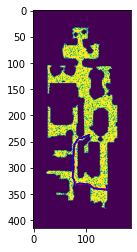

In [140]:
episode = {'episode_id': 0, 'scene_id': 'gibson_semantic/Wiconisco.glb', 'start_position': [0.5152035355567932, 0.033231496810913086, -2.4201502799987793], 'start_rotation': [-0.16431138411057558, 0.0, 0.9864085203665197, 0.0], 'object_category': 'toilet', 'object_id': 4, 'floor_id': 0, 'shortest_dist': 6.613368390177556, 'positions': [[240, 240, 0.0], [240, 240, 30.0], [242, 244, 30.0], [245, 248, 30.0], [247, 252, 30.0], [250, 257, 30.0], [252, 261, 30.0], [252, 261, 60.0], [252, 261, 90.0], [257, 261, 90.0], [257, 261, 60.0], [261, 264, 60.0], [266, 266, 60.0], [270, 269, 60.0], [274, 271, 60.0], [279, 274, 60.0], [283, 276, 60.0], [287, 279, 60.0], [292, 281, 60.0], [296, 284, 60.0], [300, 286, 60.0], [300, 286, 30.0], [300, 286, 0.0], [300, 291, 0.0], [300, 291, 30.0], [303, 295, 30.0], [303, 295, 60.0], [303, 295, 90.0], [303, 295, 120.0], [303, 295, 150.0], [304, 292, 150.0], [306, 286, 150.0], [308, 282, 150.0], [311, 278, 150.0], [313, 273, 150.0], [316, 269, 150.0], [318, 265, 150.0], [321, 260, 150.0], [323, 256, 150.0], [326, 252, 150.0], [328, 247, 150.0], [331, 243, 150.0], [333, 239, 150.0], [333, 239, 120.0], [333, 239, 90.0], [338, 239, 90.0], [338, 239, 60.0], [338, 239, 30.0], [338, 239, 0.0], [339, 242, 0.0], [339, 242, -30.0], [339, 242, -60.0], [335, 241, -60.0], [335, 241, -90.0], [335, 241, -120.0], [335, 241, -150.0], [335, 241, -180.0], [335, 241, 150.0], [338, 237, 150.0], [340, 233, 150.0], [343, 228, 150.0], [345, 224, 150.0], [347, 219, 150.0], [350, 214, 150.0], [352, 210, 150.0], [352, 210, 120.0], [352, 210, 150.0], [355, 206, 150.0], [357, 201, 150.0], [360, 197, 150.0], [362, 193, 150.0], [362, 193, -180.0], [362, 188, -180.0], [362, 188, 150.0], [365, 183, 150.0], [367, 179, 150.0], [370, 175, 150.0], [370, 175, -180.0], [370, 170, -180.0], [370, 165, -180.0], [370, 160, -180.0], [370, 155, -180.0], [370, 155, 150.0], [372, 150, 150.0], [375, 146, 150.0], [377, 142, 150.0], [380, 138, 150.0], [380, 138, -180.0], [380, 133, -180.0], [380, 133, 150.0], [383, 129, 150.0], [383, 129, -180.0], [383, 129, -150.0], [380, 124, -150.0], [378, 120, -150.0], [378, 120, -120.0], [373, 117, -120.0], [369, 115, -120.0], [365, 112, -120.0], [365, 112, -90.0], [360, 112, -90.0], [355, 112, -90.0], [350, 111, -90.0], [345, 111, -90.0], [340, 111, -90.0], [335, 111, -90.0], [330, 111, -90.0], [325, 111, -90.0], [320, 111, -90.0], [315, 111, -90.0], [311, 113, -90.0], [311, 113, -120.0], [307, 111, -120.0], [302, 108, -120.0], [302, 108, -150.0], [302, 108, -180.0], [302, 103, -180.0], [302, 103, 150.0], [302, 103, -180.0], [302, 103, -150.0], [300, 99, -150.0], [297, 94, -150.0], [297, 94, -120.0], [297, 94, -90.0], [297, 94, -60.0], [297, 94, -30.0], [297, 94, 0.0], [297, 99, 0.0], [298, 104, 0.0], [298, 104, 30.0], [300, 109, 30.0], [300, 109, 0.0], [302, 114, 0.0], [302, 114, -30.0], [299, 119, -30.0], [297, 123, -30.0], [294, 127, -30.0], [293, 132, -30.0], [290, 137, -30.0], [288, 141, -30.0], [286, 146, -30.0], [285, 150, -30.0], [282, 155, -30.0], [280, 159, -30.0], [277, 163, -30.0], [275, 168, -30.0], [272, 172, -30.0], [270, 176, -30.0], [270, 176, 0.0], [270, 181, 0.0], [270, 186, 0.0], [271, 192, 0.0], [271, 192, -30.0], [271, 192, -60.0], [267, 195, -60.0], [267, 195, -30.0], [264, 200, -30.0], [264, 200, -60.0], [260, 202, -60.0], [260, 202, -30.0], [258, 206, -30.0], [255, 211, -30.0], [253, 215, -30.0], [252, 220, -30.0], [252, 220, -60.0], [250, 223, -60.0], [246, 226, -60.0], [246, 226, -90.0], [241, 226, -90.0], [236, 226, -90.0], [231, 226, -90.0], [226, 226, -90.0], [221, 226, -90.0], [216, 226, -90.0], [211, 226, -90.0], [206, 226, -90.0], [201, 226, -90.0], [196, 226, -90.0], [191, 226, -90.0], [186, 226, -90.0], [181, 226, -90.0], [176, 226, -90.0], [171, 226, -90.0], [166, 226, -90.0], [166, 226, -60.0], [162, 228, -60.0], [158, 232, -60.0], [154, 235, -60.0], [154, 235, -90.0], [149, 235, -90.0], [149, 235, -60.0], [144, 237, -60.0], [140, 240, -60.0], [136, 242, -60.0], [131, 245, -60.0], [127, 247, -60.0], [127, 247, -90.0], [122, 247, -90.0], [122, 247, -60.0], [118, 250, -60.0], [113, 252, -60.0], [113, 252, -90.0], [113, 252, -120.0], [113, 252, -150.0], [113, 252, -120.0], [113, 252, -90.0], [113, 252, -60.0], [113, 252, -30.0], [113, 252, 0.0], [113, 252, 30.0], [113, 252, 60.0], [113, 252, 90.0], [113, 252, 120.0], [113, 252, 150.0], [116, 248, 150.0], [116, 248, 120.0], [120, 245, 120.0], [124, 243, 120.0], [129, 240, 120.0], [133, 238, 120.0], [138, 236, 120.0], [142, 233, 120.0], [142, 233, 150.0], [142, 233, -180.0], [143, 228, -180.0], [143, 223, -180.0], [143, 218, -180.0], [143, 213, -180.0], [143, 208, -180.0], [143, 203, -180.0], [143, 203, 150.0], [145, 199, 150.0], [148, 194, 150.0], [150, 190, 150.0], [153, 186, 150.0], [156, 182, 150.0], [156, 182, -180.0], [157, 177, -180.0], [157, 172, -180.0], [157, 167, -180.0], [157, 167, -150.0], [157, 167, -120.0], [153, 164, -120.0], [153, 164, -90.0], [148, 164, -90.0]], 'gt_positions': [(160, 206, 18.914466666423493), (160, 206, 48.91446653283421), (163, 209, 48.91446653283421), (167, 212, 48.91446653283421), (171, 216, 48.91446653283421), (175, 219, 48.91446653283421), (178, 222, 48.91446653283421), (178, 222, 78.91446428383033), (178, 222, 108.91446383253279), (183, 221, 108.91446383253279), (183, 221, 78.91446428383033), (188, 221, 78.91446428383033), (193, 222, 78.91446428383033), (198, 223, 78.91446428383033), (203, 224, 78.91446428383033), (208, 225, 78.91446428383033), (213, 226, 78.91446428383033), (218, 227, 78.91446428383033), (222, 228, 78.91446428383033), (227, 229, 78.91446428383033), (232, 230, 78.91446428383033), (232, 230, 48.91446653283421), (232, 230, 18.914464982084297), (234, 235, 18.914464982084297), (234, 235, 48.91446653283421), (238, 238, 48.91446653283421), (238, 238, 78.91446428383033), (238, 238, 108.91446383253279), (238, 238, 138.91446446720929), (238, 238, 168.91446235105636), (238, 234, 168.91446235105636), (237, 229, 168.91446235105636), (238, 224, 168.91446235105636), (239, 219, 168.91446235105636), (240, 214, 168.91446235105636), (241, 209, 168.91446235105636), (242, 204, 168.91446235105636), (243, 199, 168.91446235105636), (244, 194, 168.91446235105636), (245, 189, 168.91446235105636), (246, 184, 168.91446235105636), (247, 179, 168.91446235105636), (248, 175, 168.91446235105636), (248, 175, 138.9144612692789), (248, 175, 108.9144622453926), (253, 173, 108.9144622453926), (253, 173, 78.91446862442973), (253, 173, 48.914472469287716), (253, 173, 18.914471719440996), (254, 176, 18.914471719440996), (254, 176, 348.91446914931015), (254, 176, 318.9144708630702), (251, 177, 318.9144708630702), (251, 177, 288.9144678029934), (251, 177, 258.91446862442973), (251, 177, 228.91447246928774), (251, 177, 198.91447171944097), (251, 177, 168.91446914931007), (252, 172, 168.91446914931007), (253, 167, 168.91446914931007), (254, 162, 168.91446914931007), (255, 157, 168.91446914931007), (255, 151, 168.91446914931007), (256, 146, 168.91446914931007), (257, 141, 168.91446914931007), (257, 141, 138.91447086307022), (257, 141, 168.91446914931007), (258, 137, 168.91446914931007), (258, 132, 168.91446914931007), (259, 127, 168.91446914931007), (260, 122, 168.91446914931007), (260, 122, 198.91446835076272), (259, 117, 198.91446835076272), (259, 117, 168.91446575018324), (260, 112, 168.91446575018324), (261, 107, 168.91446575018324), (262, 102, 168.91446575018324), (262, 102, 198.91446329774507), (260, 98, 198.91446329774507), (258, 93, 198.91446329774507), (257, 88, 198.91446329774507), (255, 83, 198.91446329774507), (255, 83, 168.91446235105636), (256, 79, 168.91446235105636), (257, 74, 168.91446235105636), (258, 69, 168.91446235105636), (259, 64, 168.91446235105636), (259, 64, 198.91445992906674), (258, 59, 198.91445992906674), (258, 59, 168.9144589519294), (259, 54, 168.9144589519294), (259, 54, 198.91445656038826), (259, 54, 228.91446031551413), (255, 51, 228.91446031551413), (252, 48, 228.91446031551413), (252, 48, 258.914459010247), (247, 47, 258.914459010247), (242, 46, 258.914459010247), (237, 45, 258.914459010247), (237, 45, 288.9144622453926), (232, 46, 288.9144622453926), (227, 48, 288.9144622453926), (223, 49, 288.9144622453926), (218, 50, 288.9144622453926), (213, 52, 288.9144622453926), (209, 53, 288.9144622453926), (204, 55, 288.9144622453926), (199, 57, 288.9144622453926), (194, 58, 288.9144622453926), (190, 60, 288.9144622453926), (186, 63, 288.9144622453926), (186, 63, 258.91446862442973), (181, 62, 258.91446862442973), (176, 61, 258.91446862442973), (176, 61, 228.91447246928774), (176, 61, 198.91447171944097), (175, 56, 198.91447171944097), (175, 56, 168.91446914931007), (175, 56, 198.91446835076272), (175, 56, 228.9144665328342), (171, 53, 228.9144665328342), (167, 50, 228.9144665328342), (167, 50, 258.91446428383034), (167, 50, 288.91446383253276), (167, 50, 318.9144644672093), (167, 50, 348.91446235105633), (167, 50, 18.91445992906668), (169, 54, 18.91445992906668), (171, 59, 18.91445992906668), (171, 59, 48.914460315514106), (175, 62, 48.914460315514106), (175, 62, 18.914458244727456), (178, 67, 18.914458244727456), (178, 67, 348.914457252366), (177, 72, 348.914457252366), (176, 77, 348.914457252366), (175, 82, 348.914457252366), (175, 87, 348.914457252366), (174, 92, 348.914457252366), (174, 97, 348.914457252366), (174, 102, 348.914457252366), (174, 107, 348.914457252366), (173, 112, 348.914457252366), (172, 117, 348.914457252366), (171, 121, 348.914457252366), (170, 126, 348.914457252366), (169, 131, 348.914457252366), (168, 136, 348.914457252366), (168, 136, 18.91445656038826), (169, 141, 18.91445656038826), (171, 146, 18.91445656038826), (174, 150, 18.91445656038826), (174, 150, 348.91445555280256), (174, 150, 318.9144556745908), (171, 155, 318.9144556745908), (171, 155, 348.9144530034574), (170, 160, 348.9144530034574), (170, 160, 318.91445247666036), (167, 164, 318.91445247666036), (167, 164, 348.9144504541123), (166, 169, 348.9144504541123), (165, 173, 348.9144504541123), (164, 178, 348.9144504541123), (165, 183, 348.9144504541123), (165, 183, 318.91445247666036), (165, 187, 318.91445247666036), (161, 191, 318.91445247666036), (161, 191, 288.9144471597311), (157, 192, 288.9144471597311), (152, 194, 288.9144471597311), (147, 196, 288.9144471597311), (142, 197, 288.9144471597311), (138, 199, 288.9144471597311), (133, 201, 288.9144471597311), (128, 202, 288.9144471597311), (123, 204, 288.9144471597311), (119, 205, 288.9144471597311), (114, 207, 288.9144471597311), (109, 209, 288.9144471597311), (105, 210, 288.9144471597311), (100, 212, 288.9144471597311), (95, 214, 288.9144471597311), (90, 215, 288.9144471597311), (86, 217, 288.9144471597311), (86, 217, 318.9144468819717), (82, 221, 318.9144468819717), (80, 225, 318.9144468819717), (77, 229, 318.9144468819717), (77, 229, 288.9144471597311), (72, 231, 288.9144471597311), (72, 231, 318.9144468819717), (69, 234, 318.9144468819717), (65, 238, 318.9144468819717), (62, 242, 318.9144468819717), (59, 246, 318.9144468819717), (56, 249, 318.9144468819717), (56, 249, 288.9144471597311), (51, 251, 288.9144471597311), (51, 251, 318.9144468819717), (48, 255, 318.9144468819717), (44, 259, 318.9144468819717), (44, 259, 288.9144471597311), (44, 259, 258.9144493960645), (44, 259, 228.91445127040112), (44, 259, 258.9144493960645), (44, 259, 288.91445271733124), (44, 259, 318.9144548734184), (44, 259, 348.9144521536757), (44, 259, 18.914452069432826), (44, 259, 48.914451270401116), (44, 259, 78.91444939606454), (44, 259, 108.91445271733124), (44, 259, 138.91445487341835), (44, 259, 168.9144521536757), (45, 254, 168.9144521536757), (45, 254, 138.91445247666036), (48, 250, 138.91445247666036), (52, 246, 138.91445247666036), (55, 242, 138.91445247666036), (58, 239, 138.91445247666036), (62, 235, 138.91445247666036), (65, 231, 138.91445247666036), (65, 231, 168.91445045411223), (65, 231, 198.9144503850937), (64, 226, 198.9144503850937), (63, 221, 198.9144503850937), (61, 217, 198.9144503850937), (60, 212, 198.9144503850937), (58, 207, 198.9144503850937), (56, 202, 198.9144503850937), (56, 202, 168.9144511138324), (57, 197, 168.9144511138324), (58, 193, 168.9144511138324), (59, 188, 168.9144511138324), (61, 183, 168.9144511138324), (62, 178, 168.9144511138324), (62, 178, 198.91445206943285), (61, 173, 198.91445206943285), (60, 168, 198.91445206943285), (58, 164, 198.91445206943285), (58, 164, 228.91445127040112), (58, 164, 258.9144493960645), (54, 163, 258.9144493960645), (54, 163, 288.91445271733124), (49, 164, 288.91445271733124)], 'goal_rewards': [-0.31527706347992634, -0.06080621369948656, -0.19743638125018087, -0.22044643059130797, 0.06494799777006455, 0.5883579156244989, 0.42493715187002484, -0.005524445702499967, 0.22438292526348222], 'explore_rewards': [25.58387565612793, 13.648720741271973, 17.007343292236328, 12.428085327148438, 5.365732192993164, 7.563817977905273, 18.25959014892578, 14.523720741271973, 8.212577819824219], 'policy_goals': [([313, 315], 1.570914387702942), ([347, 246], 1.3548893928527832), ([446, 263], 0.9527016878128052), ([462, 91], 1.0562946796417236), ([404, 61], 0.9484309554100037), ([184, 131], 0.7558674812316895), ([154, 245], 0.5645246505737305), ([91, 265], 0.6561113595962524), ([13, 305], 1.1448367834091187), ([107, 151], 0.8486160635948181)], 'used_policy': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False], 'action': 2, 'success': 1, 'spl': 0.1649438195463693, 'distance_to_goal': 0.0, 'explored_area': 49037.38671875}
episode = {'episode_id': 1, 'scene_id': 'gibson_semantic/Wiconisco.glb', 'start_position': [-1.265192985534668, 0.033231496810913086, -1.2045917510986328], 'start_rotation': [0.9960016206576754, 0.0, 0.0893351646737389, 0.0], 'object_category': 'potted plant', 'object_id': 2, 'floor_id': 0, 'shortest_dist': 1.7219357556097445, 'positions': [[240, 240, 30.0], [240, 240, 60.0], [240, 240, 90.0], [240, 240, 120.0], [240, 240, 150.0], [242, 235, 150.0], [245, 231, 150.0], [245, 231, -180.0], [245, 226, -180.0], [245, 226, 150.0], [247, 222, 150.0], [250, 217, 150.0], [252, 213, 150.0], [256, 210, 150.0], [256, 210, -180.0], [257, 205, -180.0], [257, 200, -180.0], [257, 195, -180.0], [257, 190, -180.0], [257, 185, -180.0], [257, 180, -180.0], [257, 180, -150.0], [254, 180, -150.0], [254, 180, -180.0], [253, 179, -180.0], [253, 179, 150.0], [253, 179, 120.0], [253, 179, 90.0], [253, 179, 60.0], [253, 179, 30.0], [253, 179, 0.0], [253, 184, 0.0], [253, 189, 0.0], [253, 189, 30.0], [255, 194, 30.0], [258, 198, 30.0], [258, 198, 0.0], [258, 203, 0.0], [258, 203, -30.0], [257, 207, -30.0], [254, 212, -30.0], [252, 216, -30.0], [249, 220, -30.0], [247, 225, -30.0], [244, 229, -30.0], [244, 229, 0.0], [244, 234, 0.0], [244, 239, 0.0], [244, 244, 0.0], [244, 249, 0.0], [244, 249, -30.0], [244, 249, -60.0], [244, 249, -90.0], [239, 249, -90.0], [239, 249, -60.0], [235, 252, -60.0], [235, 252, -90.0], [230, 252, -90.0], [230, 252, -60.0], [225, 254, -60.0], [221, 257, -60.0], [217, 259, -60.0], [212, 262, -60.0], [208, 264, -60.0], [204, 267, -60.0], [204, 267, -90.0], [199, 267, -90.0], [199, 267, -60.0], [194, 269, -60.0], [190, 272, -60.0], [190, 272, -30.0], [188, 276, -30.0], [185, 280, -30.0], [183, 285, -30.0], [180, 289, -30.0], [180, 289, -60.0], [180, 289, -90.0], [180, 289, -120.0], [176, 286, -120.0], [171, 284, -120.0], [167, 281, -120.0], [167, 281, -90.0], [162, 281, -90.0], [157, 281, -90.0], [152, 281, -90.0], [147, 281, -90.0], [142, 281, -90.0], [137, 281, -90.0], [132, 281, -90.0], [127, 281, -90.0], [122, 281, -90.0], [117, 281, -90.0]], 'gt_positions': [(124, 230, 220.25072265361825), (124, 230, 250.25072203890133), (124, 230, 280.25072271774326), (124, 230, 310.2507186892544), (124, 230, 340.25072003542954), (122, 235, 340.25072003542954), (121, 239, 340.25072003542954), (121, 239, 10.250720412569194), (122, 244, 10.250720412569194), (122, 244, 340.25072171768), (120, 249, 340.25072171768), (118, 254, 340.25072171768), (116, 258, 340.25072171768), (113, 262, 340.25072171768), (113, 262, 10.250722113288987), (113, 267, 10.250722113288987), (114, 272, 10.250722113288987), (115, 277, 10.250722113288987), (116, 282, 10.250722113288987), (117, 287, 10.250722113288987), (118, 292, 10.250722113288987), (118, 292, 40.25071944704243), (121, 292, 40.25071944704243), (121, 292, 10.250719562209298), (122, 292, 10.250719562209298), (122, 292, 340.25072171768), (122, 292, 310.2507217875316), (122, 292, 280.25072271774326), (122, 292, 250.25071810903376), (122, 292, 220.25071944704243), (122, 292, 190.2507195622092), (121, 287, 190.2507195622092), (120, 282, 190.2507195622092), (120, 282, 220.25071944704243), (117, 278, 220.25071944704243), (113, 274, 220.25071944704243), (113, 274, 190.2507195622092), (113, 269, 190.2507195622092), (113, 269, 160.25072171768), (113, 265, 160.25072171768), (115, 260, 160.25072171768), (116, 255, 160.25072171768), (118, 250, 160.25072171768), (120, 246, 160.25072171768), (121, 241, 160.25072171768), (121, 241, 190.25072211328902), (120, 236, 190.25072211328902), (120, 231, 190.25072211328902), (119, 226, 190.25072211328902), (118, 221, 190.25072211328902), (118, 221, 160.25072339993042), (118, 221, 130.25072488580875), (118, 221, 100.25072271774323), (123, 220, 100.25072271774323), (123, 220, 130.25071868925443), (126, 217, 130.25071868925443), (126, 217, 100.25071747592165), (131, 216, 100.25071747592165), (131, 216, 130.25071271796534), (135, 213, 130.25071271796534), (139, 210, 130.25071271796534), (143, 207, 130.25071271796534), (147, 203, 130.25071271796534), (150, 200, 130.25071271796534), (154, 197, 130.25071271796534), (154, 197, 100.25071309701895), (159, 196, 100.25071309701895), (159, 196, 130.25070961968825), (163, 193, 130.25070961968825), (167, 190, 130.25070961968825), (167, 190, 160.25071045284693), (169, 185, 160.25071045284693), (170, 180, 160.25071045284693), (172, 176, 160.25071045284693), (174, 171, 160.25071045284693), (174, 171, 130.25070961968825), (174, 171, 100.25071309701895), (174, 171, 70.25070859278817), (178, 172, 70.25070859278817), (183, 174, 70.25070859278817), (188, 176, 70.25070859278817), (188, 176, 100.25070785519766), (193, 175, 100.25070785519766), (198, 174, 100.25070785519766), (202, 173, 100.25070785519766), (207, 172, 100.25070785519766), (212, 171, 100.25070785519766), (217, 171, 100.25070785519766), (222, 170, 100.25070785519766), (227, 169, 100.25070785519766), (232, 168, 100.25070785519766), (237, 167, 100.25070785519766)], 'goal_rewards': [0.1446088824448219, -0.011478363092380206, -0.1890472475708302], 'explore_rewards': [9.913422584533691, 10.592512130737305, 19.088817596435547], 'policy_goals': [([318, 85], 1.1555203199386597), ([150, 347], 1.2519956827163696), ([62, 283], 1.133069634437561)], 'used_policy': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False], 'action': 2, 'success': 0, 'spl': 0.0, 'distance_to_goal': 0.5250001411257316, 'explored_area': 17226.916015625}
episode = {'episode_id': 3, 'scene_id': 'gibson_semantic/Darden.glb', 'start_position': [-1.3024601936340332, 0.08354852348566055, 1.9892048835754395], 'start_rotation': [0.6702460672204769, 0.0, 0.7421389420960768, 0.0], 'object_category': 'chair', 'object_id': 0, 'floor_id': 0, 'shortest_dist': 2.526384761535655, 'positions': [[240, 240, 30.0], [240, 240, 60.0], [240, 240, 90.0], [241, 239, 90.0], [241, 239, 90.0], [241, 239, 120.0], [241, 236, 120.0], [241, 236, 90.0], [241, 236, 90.0], [241, 236, 120.0], [242, 233, 120.0], [242, 233, 90.0], [242, 232, 90.0], [242, 232, 60.0], [242, 232, 30.0], [242, 232, 60.0], [242, 232, 90.0], [242, 232, 120.0], [242, 232, 150.0], [242, 232, -180.0], [242, 232, -150.0], [242, 232, -120.0], [242, 232, -90.0], [242, 232, -60.0], [242, 232, -30.0], [242, 232, -60.0], [242, 232, -90.0], [237, 232, -90.0], [232, 232, -90.0], [227, 232, -90.0], [222, 232, -90.0], [217, 232, -90.0], [217, 232, -60.0], [212, 235, -60.0], [208, 238, -60.0], [208, 238, -90.0], [203, 239, -90.0], [198, 239, -90.0], [193, 239, -90.0], [188, 239, -90.0], [188, 239, -120.0], [184, 237, -120.0], [179, 235, -120.0], [179, 235, -150.0], [179, 235, -120.0], [179, 235, -90.0], [179, 235, -60.0], [179, 235, -30.0], [179, 235, 0.0], [179, 240, 0.0], [179, 240, -30.0], [177, 245, -30.0], [174, 249, -30.0], [174, 249, 0.0], [174, 254, 0.0], [174, 259, 0.0], [174, 264, 0.0], [174, 269, 0.0], [174, 269, -30.0], [173, 273, -30.0], [173, 273, 0.0], [173, 278, 0.0], [173, 278, -30.0], [172, 283, -30.0], [171, 287, -30.0], [171, 287, 0.0], [171, 292, 0.0], [171, 297, 0.0], [171, 302, 0.0], [171, 307, 0.0], [171, 312, 0.0], [171, 312, 30.0], [174, 317, 30.0], [176, 321, 30.0], [179, 325, 30.0], [179, 325, 60.0], [179, 325, 90.0], [184, 325, 90.0], [184, 325, 60.0], [188, 328, 60.0], [192, 330, 60.0], [197, 333, 60.0]], 'gt_positions': [(334, 139, 305.8278834804107), (334, 139, 335.82788448904057), (334, 139, 5.827884492243044), (334, 141, 5.827884492243044), (335, 141, 5.827884492243044), (335, 141, 35.82788277922592), (338, 141, 35.82788277922592), (338, 141, 5.827881081564243), (338, 141, 5.827881081564243), (338, 141, 35.82787952969653), (341, 141, 35.82787952969653), (341, 141, 5.827877670885442), (341, 141, 5.827877670885442), (341, 141, 335.8278778102481), (341, 141, 305.8278773993322), (341, 141, 335.8278778102481), (341, 141, 5.827879376224871), (341, 141, 35.82787952969653), (341, 141, 65.82788071244089), (341, 141, 95.82787974247309), (341, 141, 125.82788348041073), (341, 141, 155.82788448904063), (341, 141, 185.8278844922432), (341, 141, 215.82788277922592), (341, 141, 245.8278807124409), (341, 141, 215.82788602875522), (341, 141, 185.8278844922432), (341, 136, 185.8278844922432), (340, 131, 185.8278844922432), (340, 126, 185.8278844922432), (339, 121, 185.8278844922432), (339, 116, 185.8278844922432), (339, 116, 215.82788277922592), (336, 112, 215.82788277922592), (333, 108, 215.82788277922592), (333, 108, 185.82788108156433), (331, 103, 185.82788108156433), (331, 98, 185.82788108156433), (330, 93, 185.82788108156433), (330, 88, 185.82788108156433), (330, 88, 155.8278811496443), (331, 84, 155.8278811496443), (332, 79, 155.8278811496443), (332, 79, 125.82788348041073), (332, 79, 155.82788448904063), (332, 79, 185.8278844922432), (332, 79, 215.82788277922592), (332, 79, 245.8278807124409), (332, 79, 275.8278797424731), (327, 79, 275.8278797424731), (327, 79, 245.82787700106158), (323, 77, 245.82787700106158), (318, 75, 245.82787700106158), (318, 75, 275.8278797424731), (313, 76, 275.8278797424731), (308, 76, 275.8278797424731), (303, 77, 275.8278797424731), (298, 77, 275.8278797424731), (298, 77, 245.82787700106158), (294, 76, 245.82787700106158), (294, 76, 275.8278797424731), (289, 77, 275.8278797424731), (289, 77, 245.82787700106158), (284, 76, 245.82787700106158), (280, 76, 245.82787700106158), (280, 76, 275.8278797424731), (275, 77, 275.8278797424731), (270, 77, 275.8278797424731), (265, 78, 275.8278797424731), (260, 78, 275.8278797424731), (255, 79, 275.8278797424731), (255, 79, 305.8278834804107), (251, 82, 305.8278834804107), (247, 84, 305.8278834804107), (243, 87, 305.8278834804107), (243, 87, 335.82788448904057), (243, 87, 5.827884492243044), (243, 92, 5.827884492243044), (243, 92, 335.82788448904057), (241, 97, 335.82788448904057), (239, 102, 335.82788448904057), (237, 106, 335.82788448904057)], 'goal_rewards': [0.09013847615356296, 0.16250000000000256, -0.08291193486254304], 'explore_rewards': [9.42505931854248, 12.24526309967041, 6.417079925537109], 'policy_goals': [([299, 213], 1.062927007675171), ([170, 319], 0.7424789667129517), ([65, 443], 0.8401541113853455)], 'used_policy': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'action': 2, 'success': 1, 'spl': 0.26985416785343364, 'distance_to_goal': 0.0, 'explored_area': 12954.599609375}
#episode = {'episode_id': 1, 'scene_id': 'gibson_semantic/Darden.glb', 'start_position': [-1.5259437561035156, 0.13282066583633423, -0.8541572093963623], 'start_rotation': [-0.5497498992476785, 0.0, 0.8353293052905347, 0.0], 'object_category': 'bed', 'object_id': 3, 'floor_id': 0, 'shortest_dist': 5.829809965642916, 'positions': [[240, 240, 30.0], [240, 240, 60.0], [240, 240, 90.0], [240, 240, 120.0], [240, 240, 150.0], [240, 240, -180.0], [240, 240, -150.0], [237, 235, -150.0], [235, 231, -150.0], [232, 227, -150.0], [230, 222, -150.0], [228, 217, -150.0], [228, 217, -180.0], [228, 212, -180.0], [228, 212, -150.0], [225, 208, -150.0], [225, 208, -180.0], [225, 203, -180.0], [225, 198, -180.0], [225, 193, -180.0], [225, 188, -180.0], [225, 183, -180.0], [225, 183, 150.0], [228, 179, 150.0], [228, 179, 120.0], [228, 179, 150.0], [228, 179, -180.0], [228, 179, -150.0], [228, 179, -120.0], [223, 179, -120.0], [218, 176, -120.0], [218, 176, -150.0], [216, 172, -150.0], [213, 168, -150.0], [211, 163, -150.0], [208, 159, -150.0], [206, 155, -150.0], [206, 155, -180.0], [206, 150, -180.0], [206, 145, -180.0], [206, 140, -180.0]], 'gt_positions': [(330, 82, 96.69971364597946), (330, 82, 126.6997192461962), (330, 82, 156.6997194267442), (330, 82, 186.699719039615), (330, 82, 216.69971618843877), (330, 82, 246.69971521822106), (330, 82, 276.6997136459795), (325, 83, 276.6997136459795), (320, 83, 276.6997136459795), (315, 84, 276.6997136459795), (310, 84, 276.6997136459795), (305, 84, 276.6997136459795), (305, 84, 246.69971521822106), (300, 82, 246.69971521822106), (300, 82, 276.6997136459795), (295, 83, 276.6997136459795), (295, 83, 246.69971521822106), (291, 81, 246.69971521822106), (286, 79, 246.69971521822106), (281, 77, 246.69971521822106), (277, 75, 246.69971521822106), (272, 73, 246.69971521822106), (272, 73, 216.69971294699548), (269, 69, 216.69971294699548), (269, 69, 186.69971179493896), (269, 69, 216.69970970555204), (269, 69, 246.69971146332531), (269, 69, 276.6997136459795), (269, 69, 306.6997192461962), (267, 74, 306.6997192461962), (263, 77, 306.6997192461962), (263, 77, 276.69971818518917), (258, 77, 276.69971818518917), (253, 78, 276.69971818518917), (248, 78, 276.69971818518917), (243, 79, 276.69971818518917), (238, 80, 276.69971818518917), (238, 80, 246.699720923678), (234, 78, 246.699720923678), (229, 76, 246.699720923678), (224, 74, 246.699720923678)], 'goal_rewards': [0.3930396292556113], 'explore_rewards': [15.380990028381348], 'policy_goals': [([326, 96], 0.3836710751056671)], 'used_policy': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False], 'action': 2, 'success': 1, 'spl': 1, 'distance_to_goal': 0.0, 'explored_area': 6693.431640625}
#episode = {'episode_id': 0, 'scene_id': 'gibson_semantic/Collierville.glb', 'start_position': [-0.3094837963581085, 0.026745080947875977, -3.483508586883545], 'start_rotation': [-0.22018953669540486, 0.0, 0.9754571071707168, 0.0], 'object_category': 'toilet', 'object_id': 4, 'floor_id': 0, 'shortest_dist': 2.4882330473830008, 'positions': [[240, 240, 0.0], [240, 240, 30.0], [240, 240, 60.0], [240, 240, 90.0], [245, 240, 90.0], [250, 240, 90.0], [255, 240, 90.0], [260, 240, 90.0], [265, 240, 90.0], [270, 240, 90.0], [270, 240, 60.0], [274, 242, 60.0], [274, 242, 30.0], [274, 242, 0.0], [274, 242, 30.0], [274, 242, 60.0], [274, 242, 90.0], [274, 242, 120.0], [274, 242, 150.0], [276, 238, 150.0], [276, 238, 120.0], [281, 235, 120.0], [281, 235, 90.0], [286, 235, 90.0], [286, 235, 120.0], [286, 235, 150.0], [288, 231, 150.0], [288, 231, -180.0], [288, 226, -180.0]], 'gt_positions': [(80, 112, 25.440331195312154), (80, 112, 55.44033199358424), (80, 112, 85.44032929741772), (80, 112, 115.44032689810378), (84, 110, 115.44032689810378), (89, 108, 115.44032689810378), (93, 106, 115.44032689810378), (98, 103, 115.44032689810378), (102, 101, 115.44032689810378), (107, 99, 115.44032689810378), (107, 99, 85.44032466369279), (112, 100, 85.44032466369279), (112, 100, 55.440326101239165), (112, 100, 25.440324532755653), (112, 100, 55.44032594729626), (112, 100, 85.44032466369279), (112, 100, 115.44032689810378), (112, 100, 145.44032954583037), (112, 100, 175.44032886713762), (112, 95, 175.44032886713762), (112, 95, 145.44032751699893), (115, 90, 145.44032751699893), (115, 90, 115.44032325040804), (119, 88, 115.44032325040804), (119, 88, 145.44032425604328), (119, 88, 175.44032347684464), (120, 83, 175.44032347684464), (120, 83, 205.44032453275562), (118, 79, 205.44032453275562)], 'goal_rewards': [0.24104552696052226], 'explore_rewards': [11.66094970703125], 'policy_goals': [([339, 322], 1.5392100811004639), ([357, 168], 1.4370919466018677)], 'used_policy': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False], 'action': 2, 'success': 1, 'spl': 0.8294080957529313, 'distance_to_goal': 0.0, 'explored_area': 4664.3798828125}
#episode = {'episode_id': 0, 'scene_id': 'gibson_semantic/Darden.glb', 'start_position': [-0.8287831544876099, 0.022252321243286133, 0.9127188324928284], 'start_rotation': [-0.22018953669540486, 0.0, 0.9754571071707168, 0.0], 'object_category': 'bed', 'object_id': 3, 'floor_id': 0, 'shortest_dist': 7.317242172069304, 'positions': [[240, 240, 0.0], [240, 240, 30.0], [240, 240, 0.0], [240, 240, -30.0], [237, 244, -30.0], [235, 248, -30.0], [232, 252, -30.0], [232, 252, 0.0], [232, 257, 0.0]], 'gt_positions': [(344, 118, 25.440331195312154), (344, 118, 55.44033199358424), (344, 118, 25.44032936796998), (344, 118, 355.44032987507853), (343, 123, 355.44032987507853), (343, 128, 355.44032987507853), (342, 133, 355.44032987507853), (342, 133, 25.44032952967305), (344, 137, 25.44032952967305)], 'goal_rewards': [], 'explore_rewards': [], 'policy_goals': [([342, 150], 1.114152193069458)], 'used_policy': [True, False, False, False, False, False, False, False, False], 'action': 2, 'success': 0, 'spl': 0.0, 'distance_to_goal': 7.10680260730958, 'explored_area': 0.0}
scene = episode["scene_id"][16:-4]
sem_map = dataset_info[scene][episode["floor_id"]]["sem_map"][0]
plt.imshow(sem_map)
positions = episode["positions"]
gt_positions = episode["gt_positions"]
for step in range(1, len(gt_positions)):
    plt.plot([gt_positions[step-1][1], gt_positions[step][1]], [gt_positions[step-1][0], gt_positions[step][0]], color="red")
    x1, y1 = global_to_gt_point(positions[step-1][1], positions[step-1][0], episode)
    x2, y2 = global_to_gt_point(positions[step][1], positions[step][0], episode)
    plt.plot([x1, x2], [y1, y2], color="blue")
plt.show()